<a href="https://colab.research.google.com/github/EmeraldMath/Tensorflow_models/blob/master/tf_keras_classfication_model_deep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

TensorFlow 2.x selected.
2.1.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.17.5
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [0]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train" [None, 28, 28] -> [None, 784]
# scaler.fit_transform will record the mean and variance of training data and
# apply them into valida and test data
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
# scaler.transform instead of scaler.fit.transform for valid and test data
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [0]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    '''
    # you can also put batch normalization before activation.
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layersActivation('relu))
    '''
    '''
    # selu 自带normalization
    model.add(keras.layers.Dense(100, activation='selu'))
    '''
# AlphaDropout: 
# 1. 执行后均值和方差不变 （分布）
# 2. 归一化性质不变，从而和 batch normalization 和 selu一起使用
# Dropout 和 AlphaDropout bu bi
model.add(keras.layers.AlphaDropout(rate=0.5))
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'sgd',
              metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)              

In [0]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 'fashion_minist_model.h5')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
          validation_data=(x_valid_scaled, y_valid),
          callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 21s 386us/sample - loss: 0.6521 - accuracy: 0.7717 - val_loss: 0.4254 - val_accuracy: 0.8470
Epoch 2/10
55000/55000 [==============================] - 17s 317us/sample - loss: 0.4987 - accuracy: 0.8228 - val_loss: 0.3801 - val_accuracy: 0.8636
Epoch 3/10
55000/55000 [==============================] - 18s 323us/sample - loss: 0.4539 - accuracy: 0.8364 - val_loss: 0.3551 - val_accuracy: 0.8736
Epoch 4/10
55000/55000 [==============================] - 18s 322us/sample - loss: 0.4244 - accuracy: 0.8471 - val_loss: 0.3420 - val_accuracy: 0.8772
Epoch 5/10
55000/55000 [==============================] - 17s 309us/sample - loss: 0.3987 - accuracy: 0.8566 - val_loss: 0.3575 - val_accuracy: 0.8678
Epoch 6/10
55000/55000 [==============================] - 17s 315us/sample - loss: 0.3802 - accuracy: 0.8630 - val_loss: 0.3439 - val_accuracy: 0.8768
Epoch 7/10
55000/55000 [=====================

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir callbacks

In [0]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

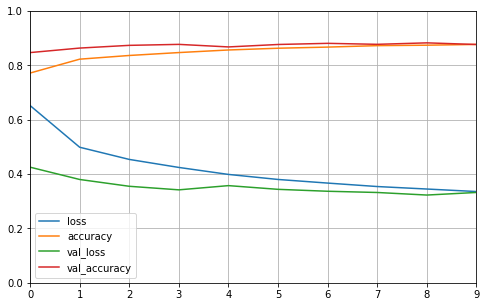

In [0]:
plot_learning_curves(history)
# too deep nn may cause loss curve not decrease rapidly 即刚开始的时候训练结果比较平缓
# 1. too many parameters, training is insufficient
# 2. gradient vanish
# 3. BatchNormalization can mitigate gradient vanish

In [0]:
model.evaluate(x_test_scaled, y_test)

10000/10000 [==============================] - 1s 101us/sample - loss: 0.3601 - accuracy: 0.8692


[0.3601263981580734, 0.8692]